In [1]:
%matplotlib inline
import torchfilter as tfilter
import numpy as np
import pandas as pd
import pymap3d as pm
from matplotlib import pyplot as plt
import plotly.express as px
import torch
from tqdm.notebook import tqdm
from collections import namedtuple
import pytorch3d.transforms as tf
import xarray as xr

/home/groups/gracegao/conda_envs/deep_gnss/lib/python3.8/site-packages/xarray/backends/cfgrib_.py:27: UserWarning: Failed to load cfgrib - most likely there is a problem accessing the ecCodes library. Try `import cfgrib` to get the full error message
  warnings.warn(


In [3]:
import os, sys
sys.path.append('..')

from dynamics_models import *
from kf_measurement_models import *
from pf_measurement_models import *
from virtual_sensor_models import *
from utils import *
from filter_models import *

%load_ext autoreload
%autoreload 2

In [4]:
def load_dd_data():
    base_path = "/home/users/shubhgup/Codes/KITTI360_Processing/TRI_KF/save_data/"
    time_gt = gps2utc(np.load(os.path.join(base_path, "time_gt.npy")))
    
    base_station_ecef = np.array([-2414266.9197,5386768.9868, 2407460.0314])
    
#     x0 = np.array([ -2418181.49, 5385962.29, 2405305.19 ]) 
#     lat0 = 22.3011999
#     lon0 = 114.1790570
#     alt0 = 3.47
    
    # utc time = 1621218838.00
    x0 = np.array([ -2418269.91, 5385974.33, 2405189.36 ]) 
    lat0 = 22.3000704
    lon0 = 114.1797920
    alt0 = 3.19
    
    
    
    base_station_enu = ecef2enu(base_station_ecef, lat0, lon0, x0)
    
    beidou_base_measurements_carr = np.load(os.path.join(base_path, "beidou_base_measurements_carr.npy"))
    beidou_base_measurements_code = np.load(os.path.join(base_path, "beidou_base_measurements_code.npy"))
    beidou_rover_measurements_carr = np.load(os.path.join(base_path, "beidou_rover_measurements_carr.npy"))
    beidou_rover_measurements_code = np.load(os.path.join(base_path, "beidou_rover_measurements_code.npy"))
    beidou_ecef_svs = np.load(os.path.join(base_path, "beidou_ecef_svs.npy"))
    beidou_enu_svs = ecef2enu(beidou_ecef_svs, lat0, lon0, x0)
    
    gps_base_measurements_carr = np.load(os.path.join(base_path, "gps_base_measurements_carr.npy"))
    gps_base_measurements_code = np.load(os.path.join(base_path, "gps_base_measurements_code.npy"))
    gps_rover_measurements_carr = np.load(os.path.join(base_path, "gps_rover_measurements_carr.npy"))
    gps_rover_measurements_code = np.load(os.path.join(base_path, "gps_rover_measurements_code.npy"))
    gps_ecef_svs = np.load(os.path.join(base_path, "gps_ecef_svs.npy"))
    gps_enu_svs = ecef2enu(gps_ecef_svs, lat0, lon0, x0)
    
    inter_const_bias = np.zeros(31 + 32)
    inter_const_bias[31:] = 17.5916
    
    return xr.Dataset(dict(
        time_gt=("t", time_gt), 
        beidou_base_measurements_carr=(["t", "sv_bei"], beidou_base_measurements_carr),
       beidou_base_measurements_code=(["t", "sv_bei"], beidou_base_measurements_code),
       beidou_rover_measurements_carr=(["t", "sv_bei"], beidou_rover_measurements_carr),
       beidou_rover_measurements_code=(["t", "sv_bei"], beidou_rover_measurements_code),
       beidou_enu_svs=(["t", "sv_bei", "pos"], beidou_enu_svs),
       gps_base_measurements_carr=(["t", "sv_gps"], gps_base_measurements_carr),
       gps_base_measurements_code=(["t", "sv_gps"], gps_base_measurements_code),
       gps_rover_measurements_carr=(["t", "sv_gps"], gps_rover_measurements_carr),
       gps_rover_measurements_code=(["t", "sv_gps"], gps_rover_measurements_code),
       gps_enu_svs=(["t", "sv_gps", "pos"], gps_enu_svs),
       base_station_enu=("pos", base_station_enu),
       inter_const_bias=("sv_all", inter_const_bias) 
      ))

In [5]:
def load_ground_truth():
    lla_rover = np.genfromtxt("/home/users/shubhgup/Codes/KITTI360_Processing/TRI_KF/medium_dataset/ground_truth.txt", delimiter = ',')
    lla0 = np.array([22.3000704, 114.1797920, 3.19])
    t_gt = lla_rover[:, 0]
    enu_rover = np.array([pm.geodetic2enu(*lla_rover[i, 1:], *lla0) for i in range(len(lla_rover))])
    return enu_rover

gt_pos = load_ground_truth()

In [6]:
dd_data = load_dd_data()

In [7]:
imu_data = xr.DataArray(pd.read_csv("/oak/stanford/groups/gracegao/HKdataset/data_06_22_22/xsense_imu_medium_urban1.csv"))

In [8]:
dynamics_model = CarFullPoseDynamicsModel()
kf_measurement_model = GNSSDDKFMeasurementModel(dd_data['base_station_enu'].to_numpy())

test_filter = AsyncExtendedKalmanFilter(
    dynamics_model=dynamics_model,
    measurement_model=kf_measurement_model,
    )

In [9]:
T_start = 25000
T = len(imu_data)
state_dim = (3+4)*2 + 31+32
estimated_states = torch.zeros(T, state_dim)
estimated_states[0, 3] = 1 
prev_timestamp = int(imu_data[T_start-1].loc['%time'])/1e9 - 0.0025 

inter_const_bias = torch.tensor(dd_data['inter_const_bias'].to_numpy())

dd_tidx = 0
dd_t = dd_data['time_gt'][dd_tidx]
while dd_t < prev_timestamp:
    dd_tidx += 1
    dd_t = dd_data['time_gt'][dd_tidx]

roll0 = -0.6671978933
pitch0 = 0.4780759843
yaw0 = 137.9359508957

quat0 = tf.matrix_to_quaternion(tf.euler_angles_to_matrix(torch.deg2rad(torch.tensor([roll0, pitch0, yaw0])), ["X", "Y", "Z"]))
quat0 = tf.quaternion_invert(quat0)

init_state = torch.zeros(state_dim)
init_state[3:7] = quat0

init_cov = torch.eye(state_dim)
init_cov[:3, :3] *= 0.1
init_cov[3:7, 3:7] *= 0.01
init_cov[7:10, 7:10] *= 0.05
init_cov[10:14, 10:14] *= 0.05

test_filter.initialize_beliefs(
            mean=init_state[None, :],
            covariance=init_cov[None, :, :],
        )
    
print("dd_t: ", int(dd_t))
print("prev_timestamp: ", prev_timestamp)

dd_t:  1621218839
prev_timestamp:  1621218838.0434425


In [10]:
# plt.imshow(torch.log(test_filter.belief_covariance.detach()[0, :, :]))

In [ ]:
for t in tqdm(range(T_start, T)):
    timestamp, or_quat, or_cov, ang_vel, ang_vel_cov, lin_acc, lin_acc_cov = parse_imu_data(imu_data[t-1])
    dt = (timestamp - prev_timestamp)
    prev_timestamp = timestamp
    or_quat = tf.quaternion_invert(or_quat)
    controls = torch.cat((lin_acc, ang_vel, or_quat)).float()
    test_filter.dynamics_model.update_dt(dt)
    estimated_states[t-T_start, :] = test_filter(controls=controls[None, :], observations=None)
    
    assert not (torch.any(torch.isnan(estimated_states[t-T_start, :])))
    if np.abs(timestamp-dd_t)<1:
        rover_code, base_code, rover_carr, base_carr, satpos, idx_code_mask, idx_carr_mask = to_tensor(read_gnss_data(dd_data, dd_tidx, 'mixed'))
        
        if sum(idx_code_mask) > 1 and sum(idx_carr_mask) > 1:
            ref = np.where(idx_code_mask & idx_carr_mask)[0][0]
            
            # Dont include reference
            idx_code_mask[ref] = False
            idx_carr_mask[ref] = False

            dd_code, dd_carr = compute_d_diff(rover_code, base_code, rover_carr, base_carr, idx_code_mask=idx_code_mask, idx_carr_mask=idx_carr_mask, ref_idx=ref)
            
            observation = data_tensor([dd_code, dd_carr])

            test_filter.measurement_model.update_sats(satpos, idx_code_mask, idx_carr_mask, ref, inter_const_bias=inter_const_bias)
            
            estimated_states[t-T_start, :] = test_filter(observations=observation[None, :], controls=None)
            
        
        dd_tidx += 1
        dd_t = dd_data['time_gt'][dd_tidx]
#         print("dd_t:", int(dd_t))
    assert not (torch.any(torch.isnan(estimated_states[t-T_start, :]))) 
    
#     measurement_model.update_sats()

  0%|          | 0/289194 [00:00<?, ?it/s]

In [1]:
tmax = t-1

root_t_s = 1621218775
lower_t_s = int(imu_data[T_start].loc['%time']/1e9)
upper_t_s = int(imu_data[tmax].loc['%time']/1e9)

states = estimated_states.detach()
plt.plot(np.linspace(1, upper_t_s-lower_t_s, num=tmax-T_start), states[:tmax-T_start, 0], "r", label="estimated_x")
plt.plot(np.linspace(1, upper_t_s-lower_t_s, num=tmax-T_start), states[:tmax-T_start, 1], "b", label="estimated_y")
plt.plot(np.linspace(1, upper_t_s-lower_t_s, num=tmax-T_start), states[:tmax-T_start, 2], "g", label="estimated_z")

plt.plot(np.linspace(1, upper_t_s-lower_t_s, num=upper_t_s-lower_t_s), gt_pos[lower_t_s-root_t_s:upper_t_s-root_t_s, 0], "r--", label="gt_x")
plt.plot(np.linspace(1, upper_t_s-lower_t_s, num=upper_t_s-lower_t_s), gt_pos[lower_t_s-root_t_s:upper_t_s-root_t_s, 1], "b--", label="gt_y")
plt.plot(np.linspace(1, upper_t_s-lower_t_s, num=upper_t_s-lower_t_s), gt_pos[lower_t_s-root_t_s:upper_t_s-root_t_s, 2], "g--", label="gt_z")

# plt.plot(gt_pos[lower_t_s-root_t_s:, 0], "r--", label="gt_x")
# plt.plot(gt_pos[lower_t_s-root_t_s:, 1], "b--", label="gt_y")
# plt.plot(gt_pos[lower_t_s-root_t_s:, 2], "g--", label="gt_z")

plt.legend()

NameError: name 't' is not defined

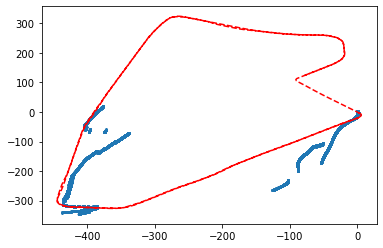

In [19]:
plt.scatter(states[:tmax-T_start, 0], states[:tmax-T_start, 1], s=1)
plt.plot(gt_pos[lower_t_s-root_t_s:, 0], gt_pos[lower_t_s-root_t_s:, 1], "r--")

In [ ]:
# observation_dim = test_filter.measurement_model.observation_dim

# def temp_f(states, satXYZb, base_pos, ref_idx, idx_code_mask, idx_carr_mask):
#     N, state_dim = states.shape
#     pos = states[:, :3]
# #         bias = states[:, self.idx_b_mask]

#     # ROVER
#     expected_observation_code = torch.linalg.norm(satXYZb[None, idx_code_mask, :3] - pos[:, None, :], dim=-1)
#     expected_observation_carr = torch.linalg.norm(satXYZb[None, idx_carr_mask, :3] - pos[:, None, :], dim=-1)


#     # ROVER - BASE
#     expected_observation_code -= torch.linalg.norm(satXYZb[None, idx_code_mask, :3] - base_pos[None, None, :], dim=-1)
#     expected_observation_carr -= torch.linalg.norm(satXYZb[None, idx_carr_mask, :3] - base_pos[None, None, :], dim=-1)

    
#     ## REFERENCE
    
#     # ROVER
#     expected_observation_code_ref = torch.linalg.norm(satXYZb[None, ref_idx, :3] - pos[:, :], dim=-1)
#     expected_observation_carr_ref = torch.linalg.norm(satXYZb[None, ref_idx, :3] - pos[:, :], dim=-1)


#     # ROVER - BASE
#     expected_observation_code_ref -= torch.linalg.norm(satXYZb[None, ref_idx, :3] - base_pos[None, :], dim=-1)
#     expected_observation_carr_ref -= torch.linalg.norm(satXYZb[None, ref_idx, :3] - base_pos[None, :], dim=-1)
    
    
#     # DOUBLE DIFFERENCE
#     expected_observation_code = expected_observation_code - expected_observation_code_ref[:, None]
#     expected_observation_carr = expected_observation_carr - expected_observation_carr_ref[:, None]

#     expected_observation = torch.cat((expected_observation_code, expected_observation_carr), -1)

#     return expected_observation.float()

# with torch.enable_grad():
#     x = pred_mean.detach().clone()

#     N, ndim = x.shape
    
#     x = x[:, None, :].expand((N, observation_dim, ndim))
#     x.requires_grad_(True)
#     y = test_filter.measurement_model(x.reshape((-1, ndim)))[0].reshape((N, -1, observation_dim))
#     mask = torch.eye(observation_dim, device=x.device).repeat(N, 1, 1)
#     jac = torch.autograd.grad(y, x, mask, create_graph=True)
# jac[0]

In [29]:
# ## Fiter

# t = 1
# timestamp, or_quat, or_cov, ang_vel, ang_vel_cov, lin_acc, lin_acc_cov = parse_imu_data(imu_data[t-1])
# dt = (timestamp - prev_timestamp)
# prev_timestamp = timestamp
# or_quat = tf.quaternion_invert(or_quat)
# controls = torch.cat((lin_acc, ang_vel, or_quat)).float()

# prev_mean = test_filter._belief_mean
# prev_covariance = test_filter._belief_covariance
# N, state_dim = prev_mean.shape

# # Compute mu_{t+1|t}, covariance, and Jacobian
# pred_mean, dynamics_tril = test_filter.dynamics_model(
#     initial_states=prev_mean, controls=controls[None, :]
# )

# dynamics_covariance = dynamics_tril @ dynamics_tril.transpose(-1, -2)
# dynamics_A_matrix = test_filter.dynamics_model.jacobian(
#     initial_states=prev_mean, controls=controls[None, :]
# )

# # Calculate Sigma_{t+1|t}
# pred_covariance = (
#     dynamics_A_matrix @ prev_covariance @ dynamics_A_matrix.transpose(-1, -2)
#     + dynamics_covariance
# )

# test_filter.measurement_model.update_sats(satpos, idx_code_mask, idx_carr_mask, ref)

# observations = observation[None, :]
# # Measurement model forward pass, Jacobian
# observations_mean = observations
# pred_observations, observations_tril = test_filter.measurement_model(states=pred_mean)
# observations_covariance = observations_tril @ observations_tril.transpose(
#     -1, -2
# )

# print(pred_mean)

# C_matrix = test_filter.measurement_model.jacobian(states=pred_mean)
# # Compute Kalman Gain, innovation
# innovation = observations_mean - pred_observations
# innovation_covariance = (
#     C_matrix @ pred_covariance @ C_matrix.transpose(-1, -2)
#     + observations_covariance
# )
# kalman_gain = (
#     pred_covariance
#     @ C_matrix.transpose(-1, -2)
#     @ torch.inverse(innovation_covariance)
# )

# # Get mu_{t+1|t+1}, Sigma_{t+1|t+1}
# corrected_mean = pred_mean + (kalman_gain @ innovation[:, :, None]).squeeze(-1)

# identity = torch.eye(test_filter.state_dim, device=kalman_gain.device)
# corrected_covariance = (identity - kalman_gain @ C_matrix) @ pred_covariance

tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  3.8001e-01, -5.7320e-03,
         -4.6546e-03, -9.2426e-01,  8.0929e-05,  3.0421e-04, -2.4306e-04,
         -4.1550e-03, -4.2301e-03,  2.5471e-02, -1.7786e-03]])


In [ ]:
# ## DEBUG

# rover_code = dd_data[constellation+'_rover_measurements_code'][dd_tidx].to_numpy()
# base_code = dd_data[constellation+'_base_measurements_code'][dd_tidx].to_numpy()

# rover_carr = dd_data[constellation+'_rover_measurements_carr'][dd_tidx].to_numpy()
# base_carr = dd_data[constellation+'_base_measurements_carr'][dd_tidx].to_numpy()

# idx_code_mask = np.logical_not(np.isnan(rover_code))
# idx_carr_mask = np.logical_not(np.isnan(rover_carr))

# satpos = torch.tensor(dd_data[constellation+'_ecef_svs'][dd_tidx].to_numpy())
# ref = np.where(idx_code_mask & idx_carr_mask)[0][0]

# sd_code = rover_code - base_code
# dd_code = sd_code - sd_code[ref]

# sd_carr = rover_carr - base_carr
# dd_carr = sd_carr - sd_carr[ref]

# # Dont include reference
# idx_code_mask[ref] = False
# idx_carr_mask[ref] = False

# observation = torch.tensor(np.concatenate((dd_code[idx_code_mask], dd_carr[idx_carr_mask]), -1), dtype=torch.float32)

# kf_measurement_model.update_sats(satpos, idx_code_mask, idx_carr_mask, ref)

# print("expected: ", kf_measurement_model(estimated_states[0, :][None, :])[0])
# print("measured: ", observation)

# Residual Computation

In [113]:
# # Print number of measurements at each time
# sum(~np.isnan(dd_data.beidou_base_measurements_carr).T)

In [119]:
# Residual computation
T = len(dd_data['time_gt'])
code_sd_residuals = torch.zeros(T, 32+31).float()
code_sd_residuals[...] = float('nan') 
carr_sd_residuals = torch.zeros(T, 32+31).float()
carr_sd_residuals[...] = float('nan')
base_pose = torch.tensor(dd_data['base_station_enu'].to_numpy())[None, :]


for dd_tidx in tqdm(range(T)):
    rover_code, base_code, rover_carr, base_carr, satpos, idx_code_mask, idx_carr_mask = to_tensor(read_gnss_data(dd_data, dd_tidx, 'mixed'))
    if sum(idx_code_mask) > 1 and sum(idx_carr_mask) > 1:
        dd_code, dd_carr = compute_s_diff(rover_code, base_code, rover_carr, base_carr, idx_code_mask=idx_code_mask, idx_carr_mask=idx_carr_mask)

        dd_code_expec, dd_carr_expec = expected_s_diff(satpos, torch.tensor(gt_pos[None, dd_tidx, :3]), base_pose, idx_code_mask=idx_code_mask, idx_carr_mask=idx_carr_mask)
        code_sd_residuals[dd_tidx, idx_code_mask] = dd_code.float() - dd_code_expec[0, :].float()
        carr_sd_residuals[dd_tidx, idx_carr_mask] = dd_carr.float() - dd_carr_expec[0, :].float()


  0%|          | 0/777 [00:00<?, ?it/s]

In [162]:
# Possible references
torch.where(torch.sum(~torch.isnan(code_sd_residuals), dim=0)>0)

(tensor([ 0,  3,  6,  7,  8, 14, 19, 25, 32, 33, 46, 47, 49]),)

tensor(0.) tensor(17.5916)


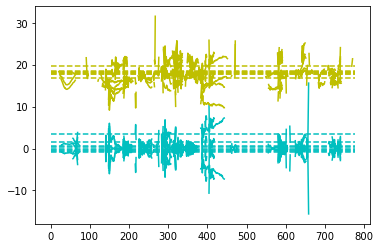

In [172]:
def calc_icb(residuals, ref=-1, const1_max_idx=31, plot=True):
    max_idx = residuals.shape[1]
    
    if plot:
        for idx in range(const1_max_idx):
            if idx==ref:
                continue
            plt.plot(residuals[:, idx], 'c')

        for idx in range(const1_max_idx, max_idx):
            if idx==ref:
                continue
            plt.plot(residuals[:, idx], 'y')

    tmp_mask = torch.ones(max_idx, dtype=torch.bool)
    tmp_mask[const1_max_idx:] = False
    if ref>=0:
        tmp_mask[ref] = False
    icb1_res = residuals[:, tmp_mask]
    if plot:
        plt.plot(torch.ones(len(residuals))*torch.nanmean(icb1_res), 'c--')

    tmp_mask = torch.ones(max_idx, dtype=torch.bool)
    tmp_mask[:const1_max_idx] = False
    if ref>=0:
        tmp_mask[ref] = False
    icb2_res = residuals[:, tmp_mask]
    if plot:
        plt.plot(torch.ones(len(residuals))*torch.nanmean(icb2_res), 'y--')
    return icb1_res, icb2_res

all_icb1_res = []
all_icb2_res = []
for ref in [0,  3,  6,  7,  8, 14, 19, 25]:
    code_dd_residuals = code_sd_residuals - code_sd_residuals[:, [ref]]
    carr_dd_residuals = carr_sd_residuals - carr_sd_residuals[:, [ref]]
    icb1_res, icb2_res = calc_icb(code_dd_residuals, ref=ref)
    all_icb1_res.append(icb1_res)
    all_icb2_res.append(icb2_res)
all_icb1_res = torch.stack(all_icb1_res)
all_icb2_res = torch.stack(all_icb2_res)

print(torch.nanmean(all_icb1_res), torch.nanmean(all_icb2_res))